# <center>Physics-informed neural network</center>

Se analizará el desempeño de diferentes funciones de activación sobre distintos optimizadores (incluyendo L-BFGS). Para esto, se resolverá la siguiente EDP:

$$
\begin{align}
\Delta u(x,y) & = -x\cos(x) + 2\cos(y) - 2\sin(x) - y\sin(y), & (x,y)\in[-2\pi, 2\pi]\times[-2\pi, 2\pi]\\
u(x, y) & = x\cos(x) + y\sin(y), & (x,y)\in\partial\left([-2\pi, 2\pi]\times[-2\pi, 2\pi]\right)\\
\end{align}
$$

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import random

import warnings
warnings.filterwarnings('ignore')

#### Red neuronal

In [2]:
class NeuralNetwork(nn.Module):

    def __init__(self, n_layers, wide, activation):
        super().__init__()
        self.inner_layers = nn.ModuleList([nn.Linear(2 if n == 0 else wide, wide)
                                           for n in range(n_layers - 1)])
        self.last_layer = nn.Linear(wide, 1)
        self.activation = activation
    
    def forward(self, x, y):
        input = torch.cat([x, y], axis=1)
        
        for layer in self.inner_layers:
            input = self.activation()(layer(input))
        input = self.last_layer(input)
        
        return input

In [3]:
def derivative(f, variable):
    return torch.autograd.grad(f.sum(), variable, create_graph=True)[0]

#### PDE

In [4]:
cos, sin, pi = torch.cos, torch.sin, torch.pi
x_domain, y_domain = [-2*pi, 2*pi], [-2*pi, 2*pi]

def pde(x, y, net):
    u = net(x, y)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    u_y = derivative(u, y)
    u_yy = derivative(u_y, y)
    return u_xx + u_yy - (-x*cos(x) + 2*cos(y) - 2*sin(x) - y*sin(y))

def boundary_condition(x, y):
    return x*cos(x) + y*sin(y)

def analytical_solution(x, y):
    return x*cos(x) + y*sin(y)

#### Entrenamiento

In [5]:
optimizers_list = ('Adam', 'LBFGS', 'RMSprop', 'Adadelta', 'Adagrad', 'AdamW')
activations_list = ('Tanh', 'ReLU', 'Sigmoid', 'LeakyReLU', 'GELU', 'SiLU', 'ELU', 'SELU')

# Parámetros de entrenamiento:
samples_boundary, samples_collocation = 500, 500
epochs = {key: 2000 if key != 'LBFGS' else 500 for key in optimizers_list}

In [6]:
# Puntos para el entrenamiento:

x_boundary = torch.empty(samples_boundary, 1).uniform_(*x_domain)
y_boundary = torch.empty(samples_boundary, 1).uniform_(*y_domain)

for n_sample in range(samples_boundary):
    set_var = random.choice([0, 1])
    x_boundary[n_sample, 0] = random.choice(x_domain) if set_var == 0 else random.uniform(*x_domain)
    y_boundary[n_sample, 0] = random.choice(y_domain) if set_var == 1 else random.uniform(*y_domain)

target_boundary = boundary_condition(x_boundary, y_boundary)

x_collocation = torch.empty(samples_collocation, 1).uniform_(*x_domain).requires_grad_()
y_collocation = torch.empty(samples_collocation, 1).uniform_(*y_domain).requires_grad_()
target_collocation = torch.zeros(samples_collocation, 1)

# Entrenamiento:
losses, nets, optimizers = {}, {}, {}

for method in optimizers_list:
    
    losses[method], nets[method], optimizers[method] = {}, {}, {}
    
    for activation in activations_list:
        
        nets[method][activation] = NeuralNetwork(n_layers=2, wide=20, activation=getattr(nn, activation))
        optimizers[method][activation] = getattr(optim, method)(nets[method][activation].parameters())
        losses[method][activation] = []
        
        def calc_loss():
            u_boundary = nets[method][activation](x_boundary, y_boundary)     
            loss_boundary = nn.MSELoss()(u_boundary, target_boundary)

            pde_collocation = pde(x_collocation, y_collocation, nets[method][activation])
            loss_collocation = nn.MSELoss()(pde_collocation, target_collocation)
            
            return loss_collocation + loss_boundary

        def closure():
            optimizers[method][activation].zero_grad()
            loss = calc_loss()
            loss.backward()
            return loss
        
        for epoch in range(1, epochs[method] + 1):
            optimizers[method][activation].step(closure)
            losses[method][activation].append(calc_loss().item())
            
    print(method, 'ok.')

Adam ok.
LBFGS ok.
RMSprop ok.
Adadelta ok.
Adagrad ok.
AdamW ok.


#### Evolución del error

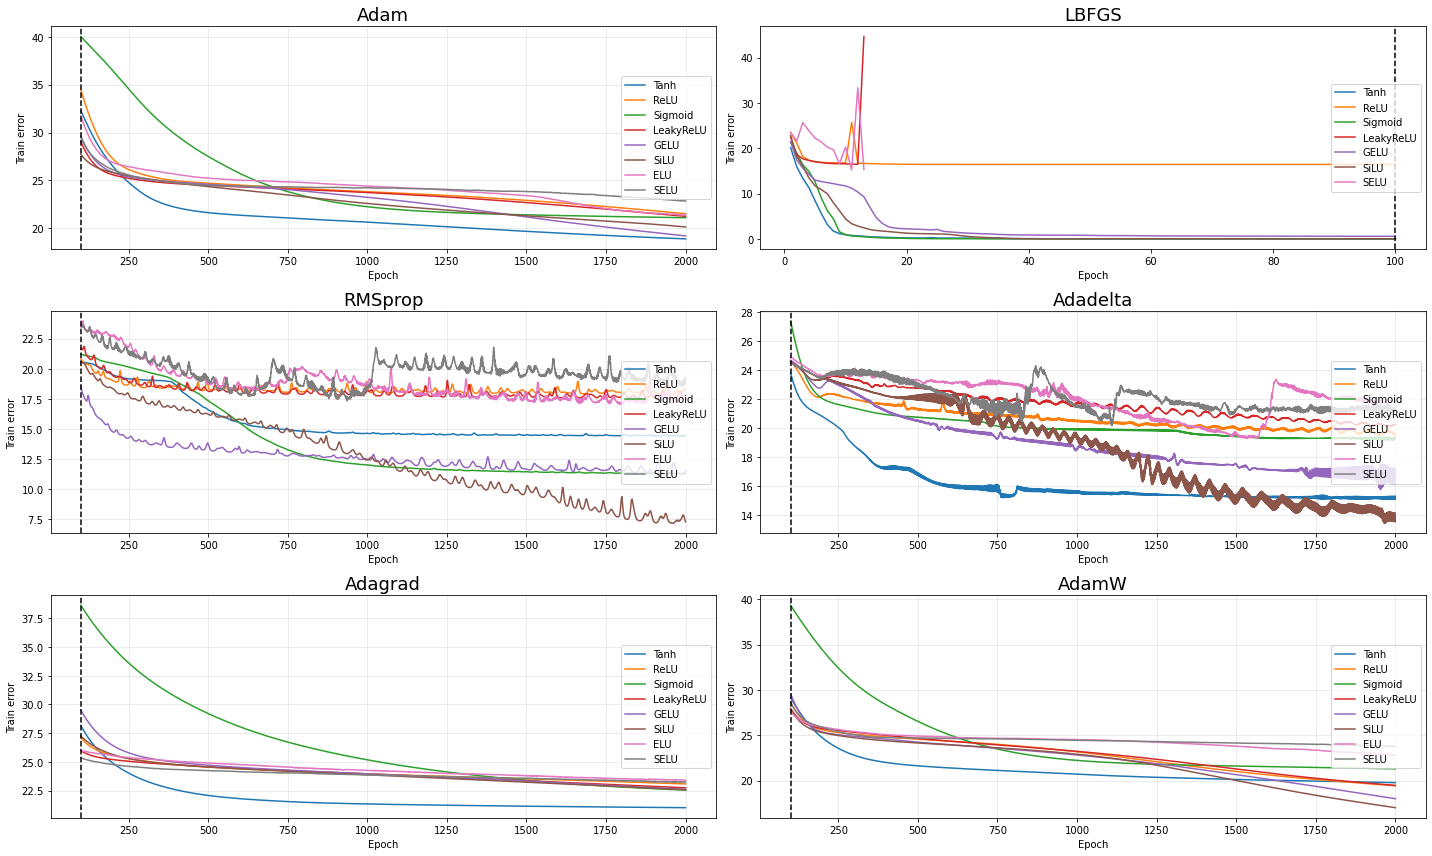

In [14]:
first_epoch = 100
last_epoch_lbfgs = 100

n_plots = len(optimizers_list)
fig = plt.figure(figsize=(20, 2*n_plots))

for n_plot, method in enumerate(optimizers_list):
    ax = fig.add_subplot(n_plots//2, 2, n_plot + 1)
    
    for activation in activations_list:
        
        if method == 'LBFGS':
            if activation in ('ELU'): continue
            epochs_range = torch.arange(1, last_epoch_lbfgs + 1, 1)
            ax.plot(epochs_range, losses[method][activation][:last_epoch_lbfgs], label=activation)
            continue
        
        epochs_range = torch.arange(first_epoch, epochs[method] + 1, 1)
        ax.plot(epochs_range, losses[method][activation][first_epoch-1:], label=activation)
        ax.grid(alpha=0.3)
    ax.axvline(first_epoch, linestyle='--', color='k')
    ax.legend(loc='center right')
    ax.set_title(method, fontsize=18)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Train error')
plt.tight_layout()
plt.show()

#### Simulación y comparación con la solución real

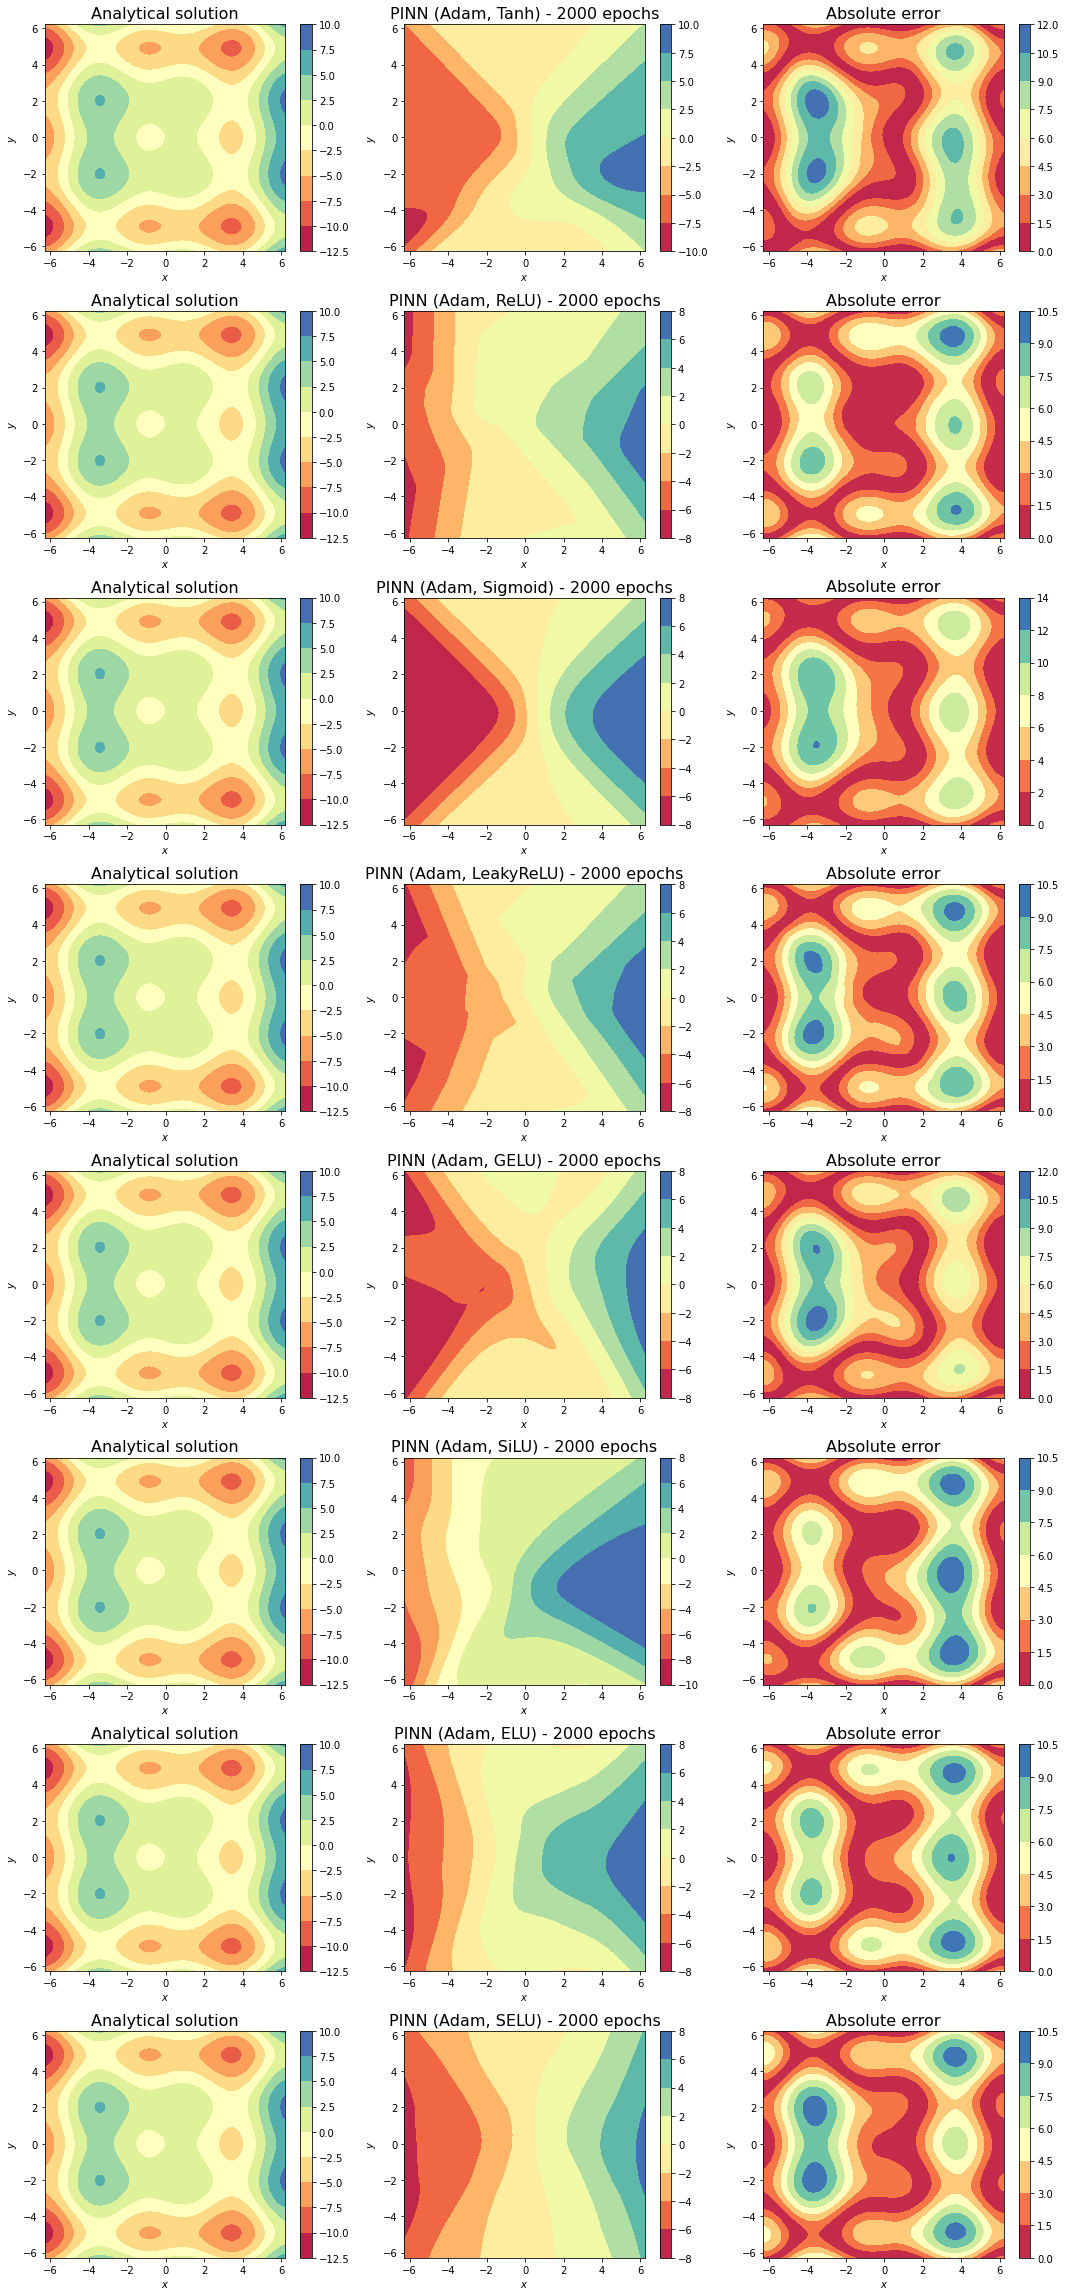

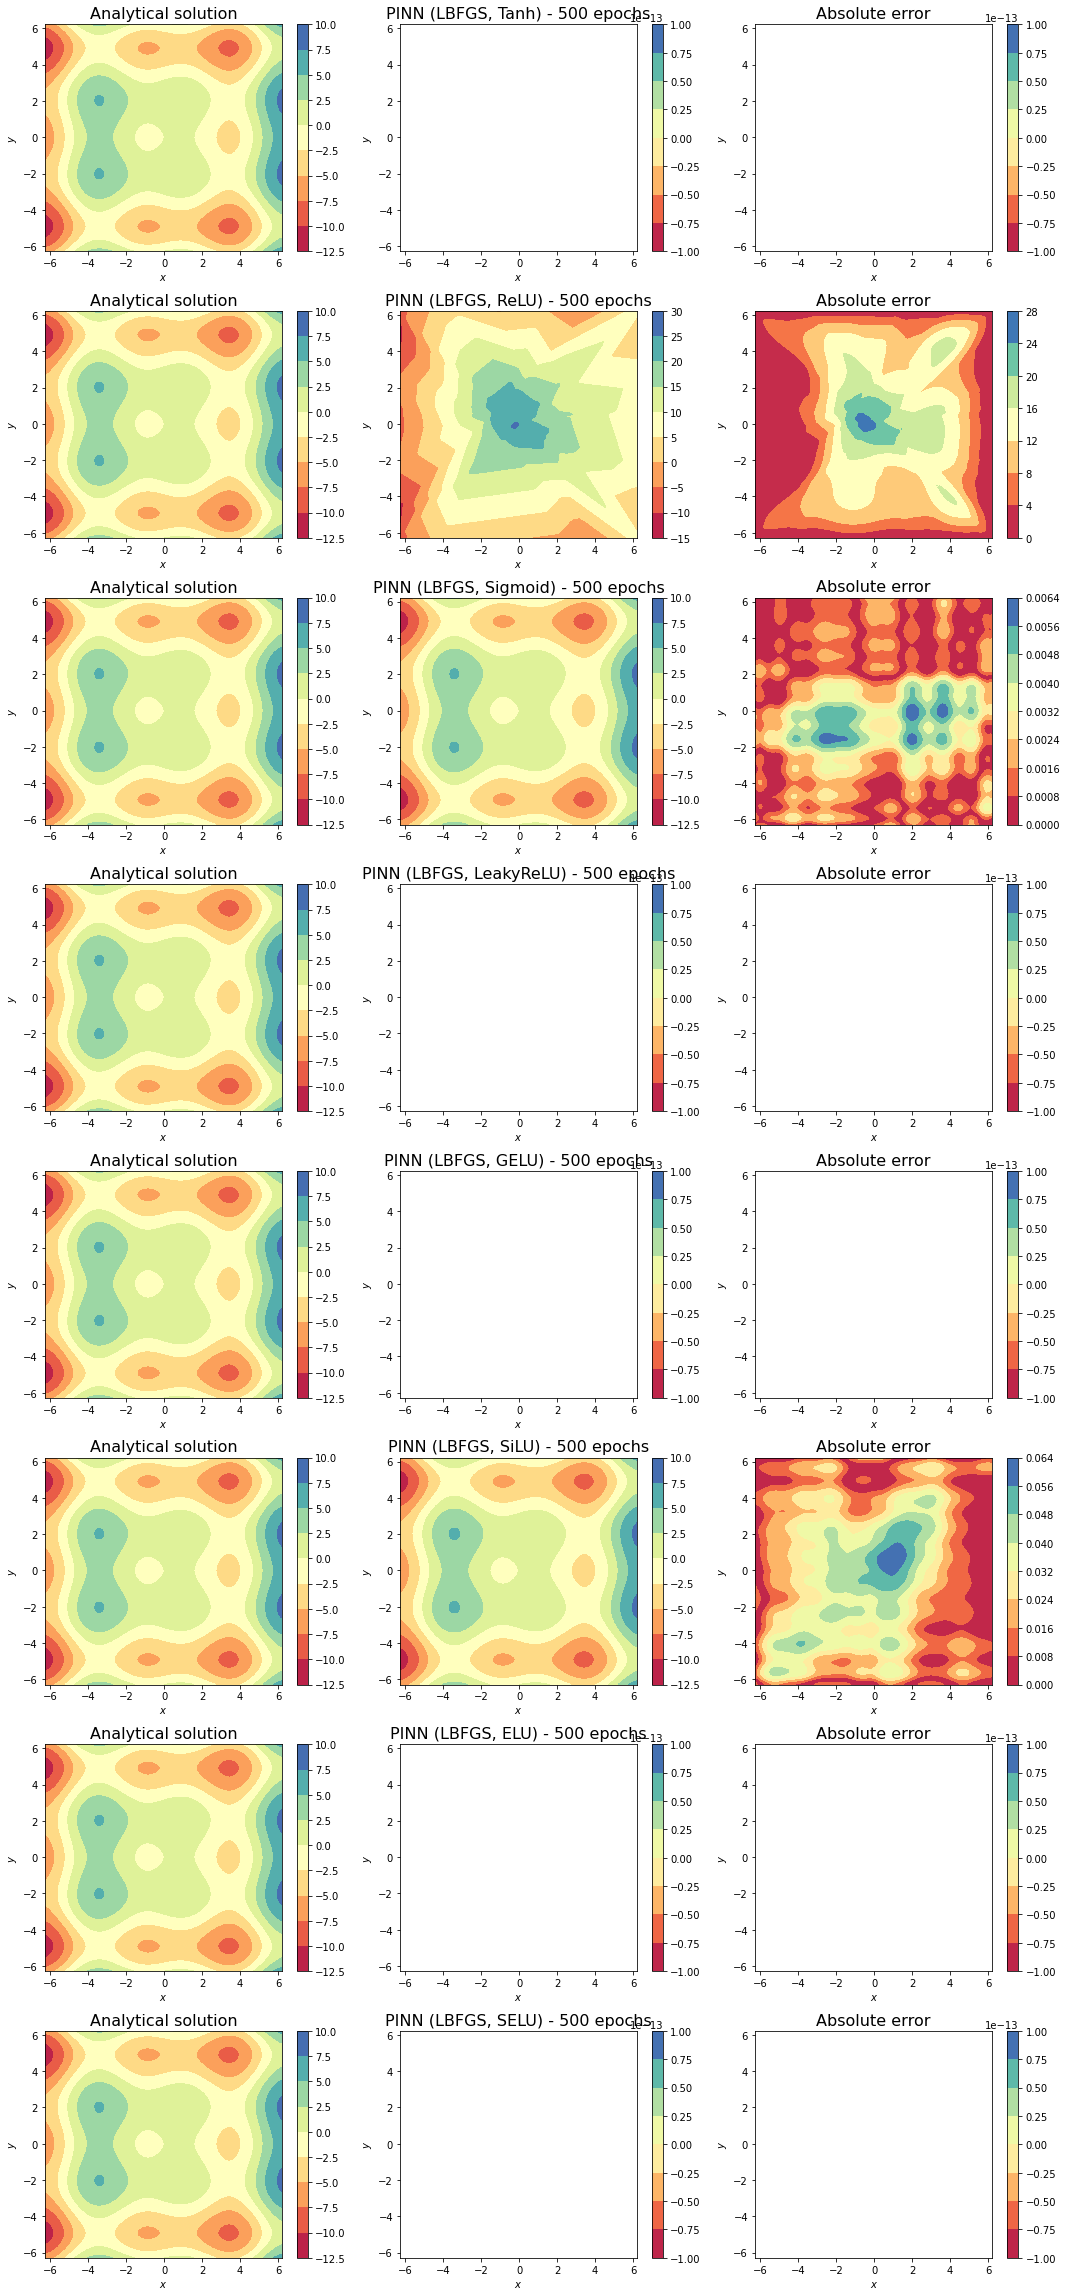

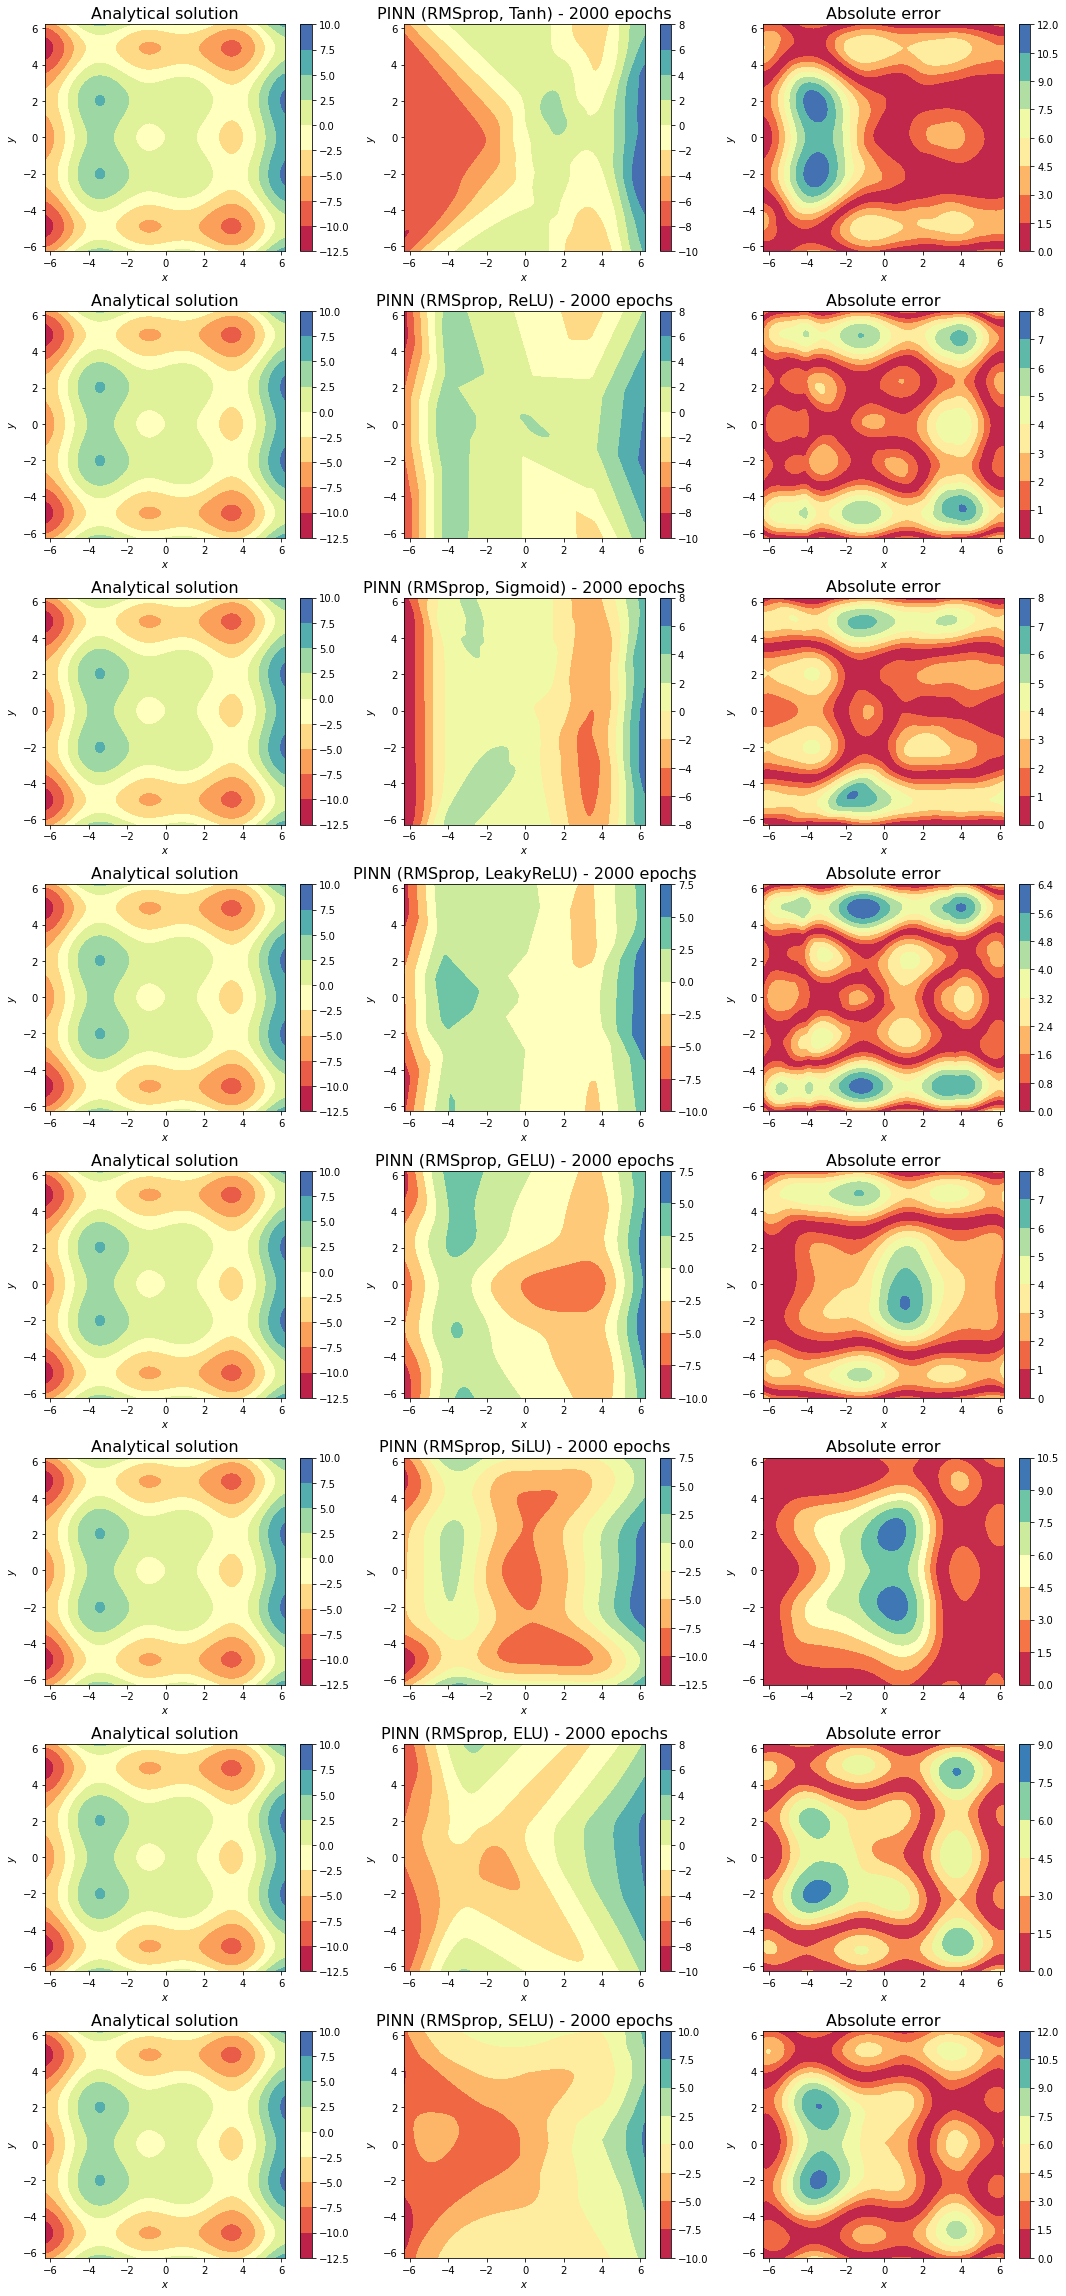

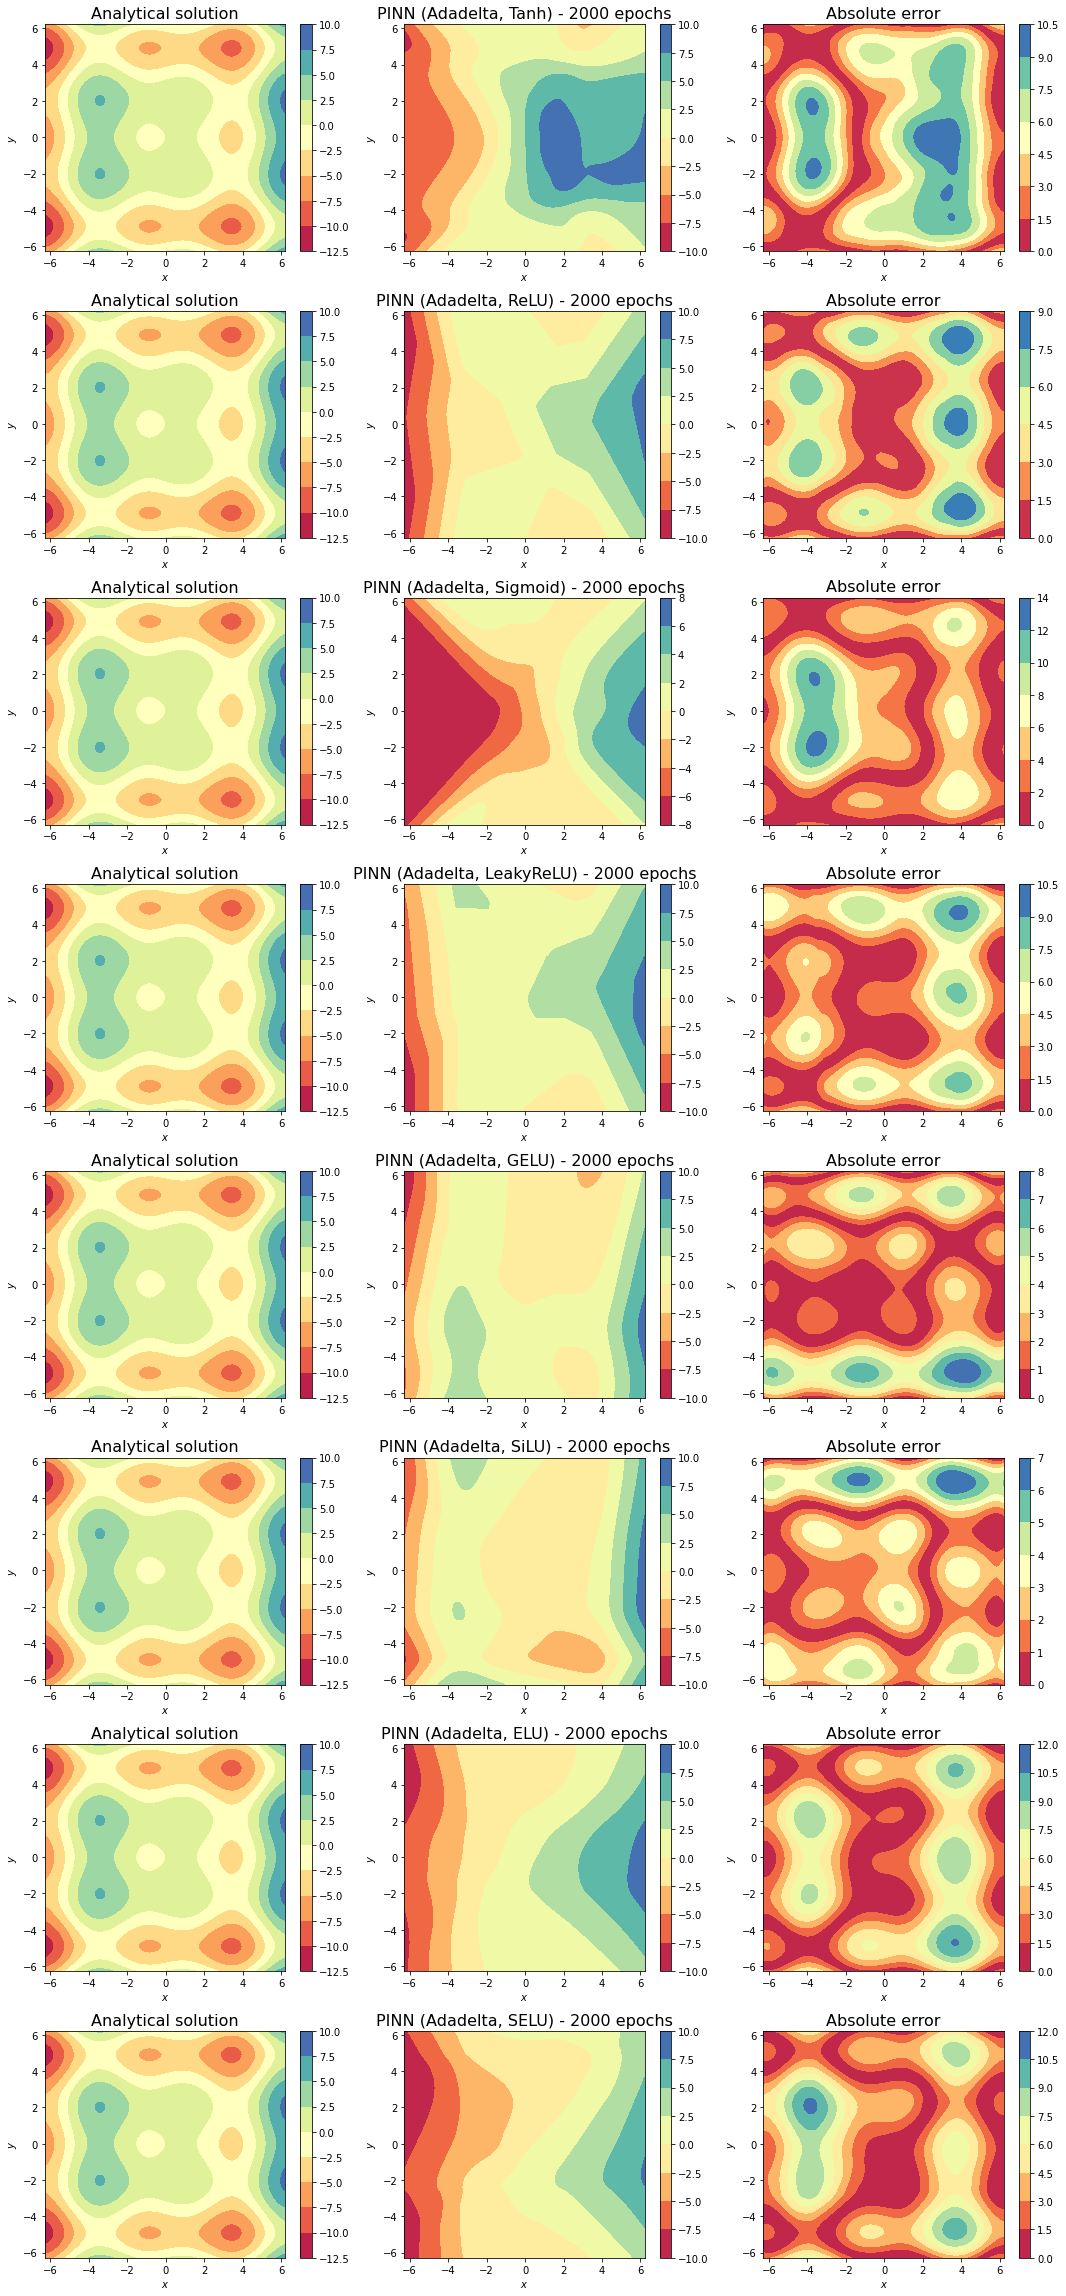

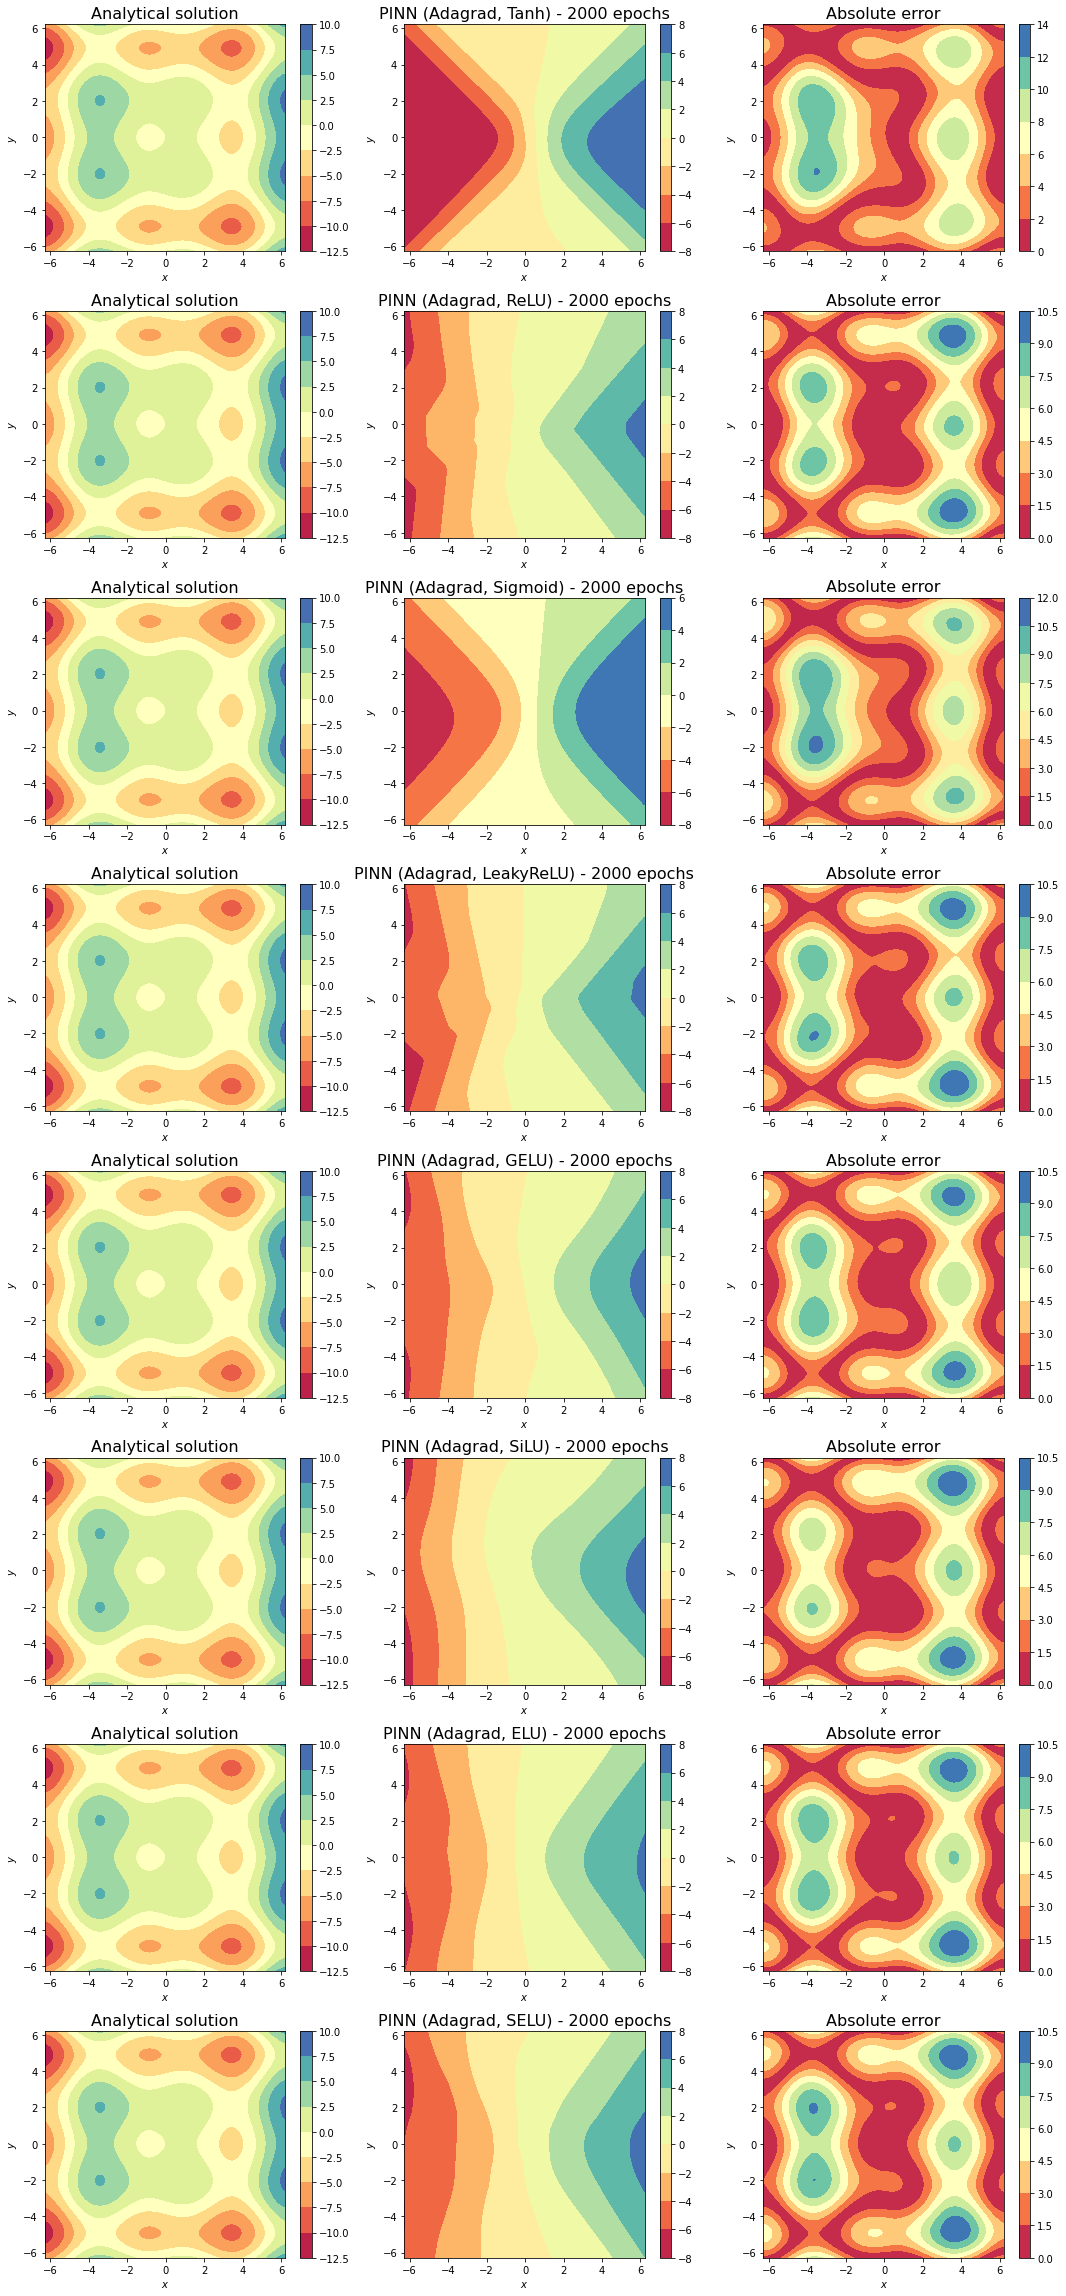

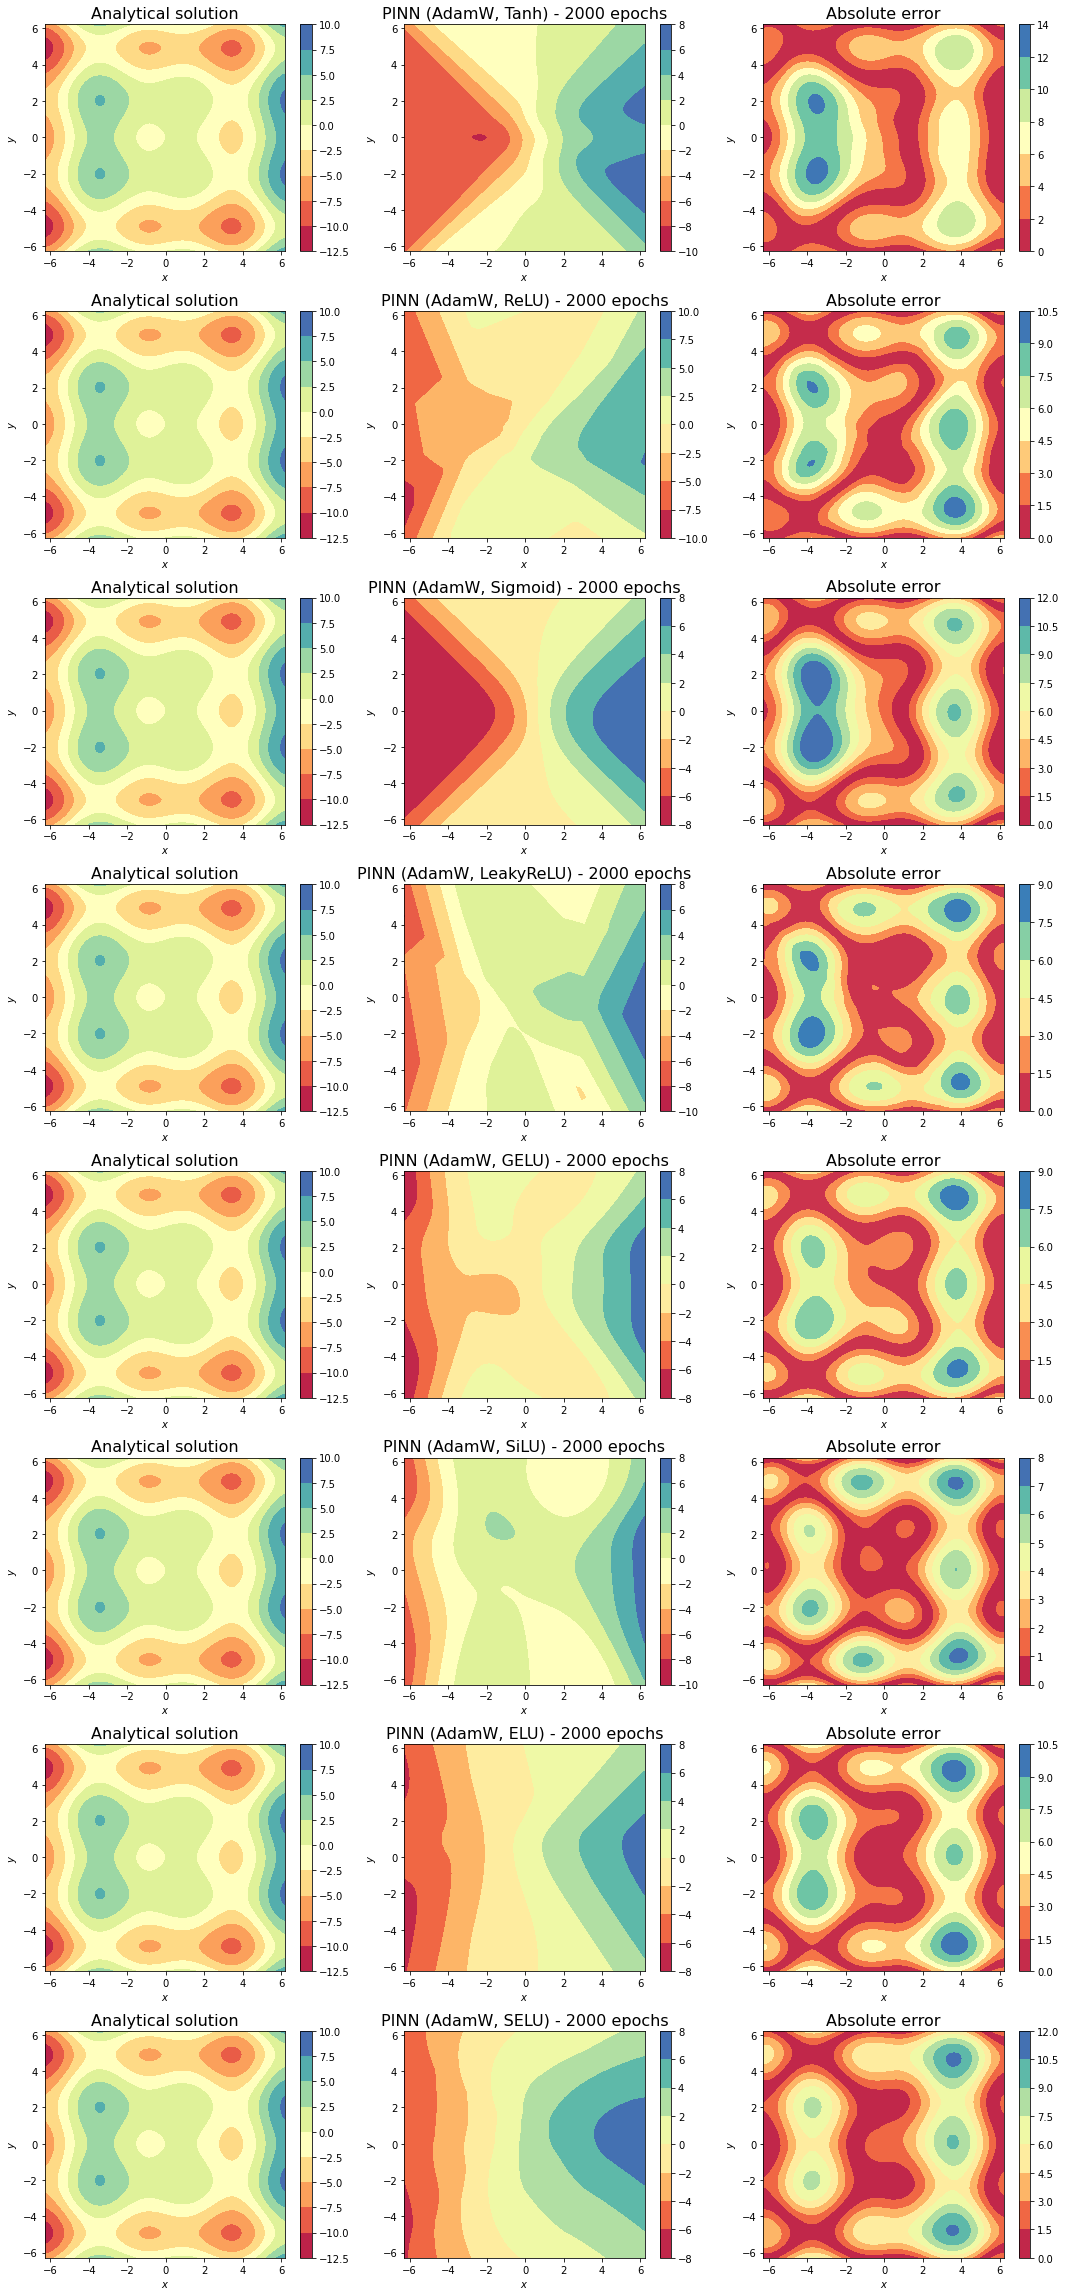

In [8]:
x = torch.arange(*x_domain, 1e-1)
y = torch.arange(*y_domain, 1e-1)
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij')
input = grid_x.reshape(-1, 1), grid_y.reshape(-1, 1)

u_real = analytical_solution(*input)
n_plots = len(activations_list)

for method in optimizers_list:

    fig = plt.figure(figsize=(15, 4*n_plots))
    for i, activation in enumerate(activations_list):
            
        nets[method][activation].eval()
        u_pred = nets[method][activation](*input).detach()
        error = torch.abs(u_real - u_pred)
        
        plot_title = f'PINN ({method}, {activation}) - {epochs[method]} epochs'
        titles = ('Analytical solution', plot_title, 'Absolute error')
        for j, value in enumerate((u_real, u_pred, error)):    
            ax = fig.add_subplot(n_plots, 3, 3*i+j+1)
            simulation = ax.contourf(grid_x, grid_y, value.reshape_as(grid_x), cmap='Spectral')
            plt.colorbar(simulation)
            ax.set_title(titles[j], fontdict={'size': 16})
            ax.set_xlabel('$x$'); ax.set_ylabel('$y$')

    plt.tight_layout()
    plt.show()